In [12]:
import os
import sys
import numpy as np

from joblib import delayed
from tqdm_joblib import ParallelPbar

from histomicstk.preprocessing.\
    color_conversion import rgb_to_lab, lab_mean_std, rgb_to_hsi
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask, threshold_multichannel)

sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
from GenericTiffHandler import GenericTiffHandler as genTiff

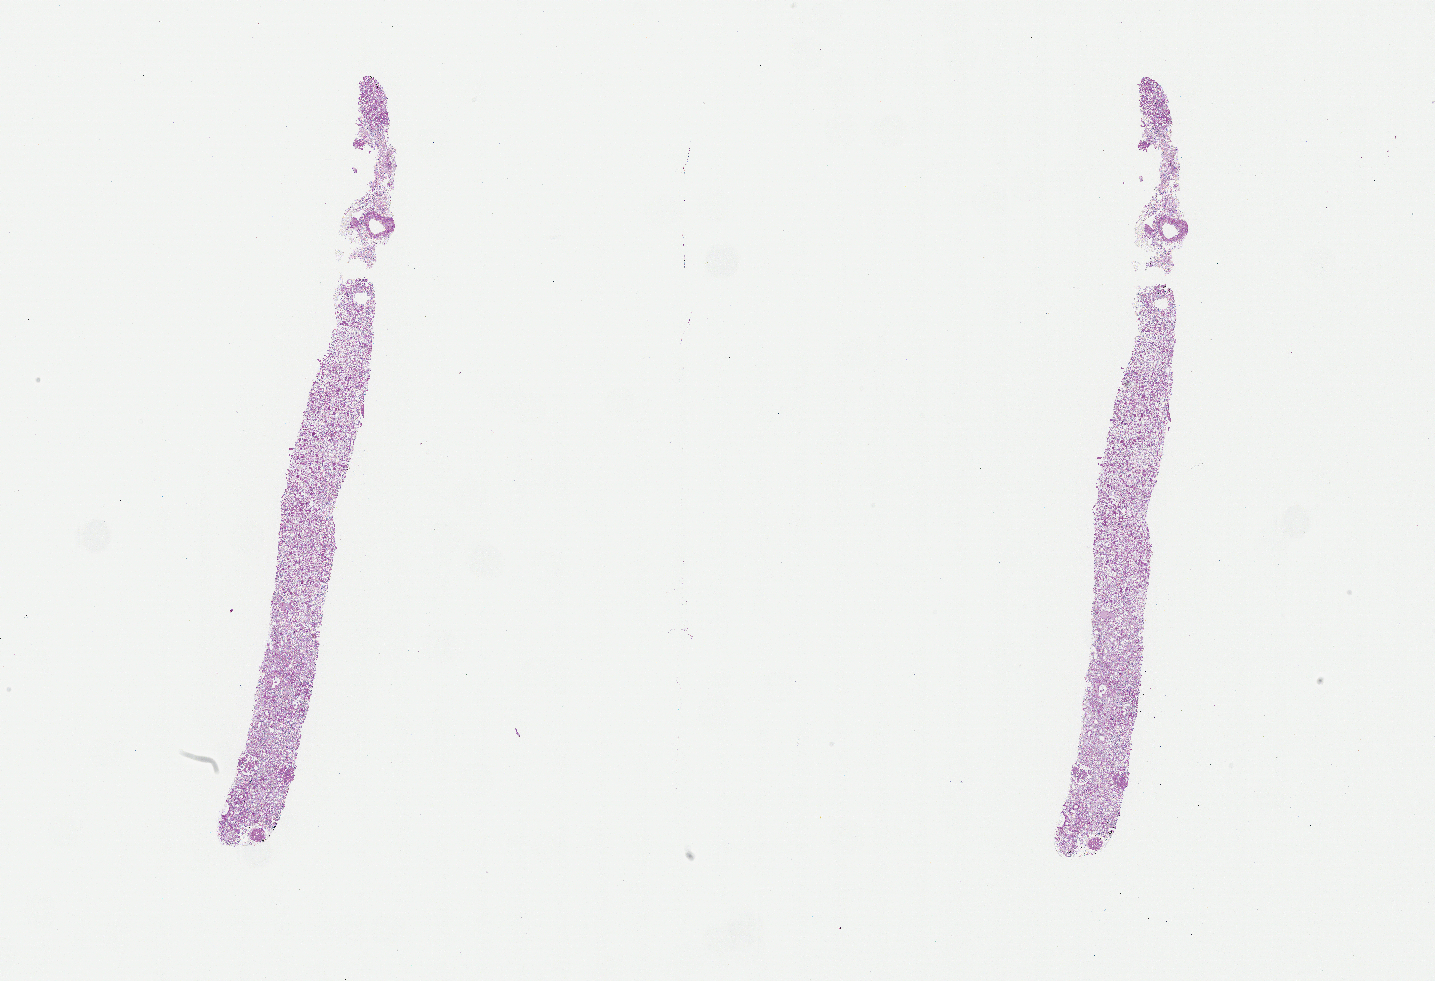

In [ ]:
# Load the slide
slide_path = "PATH/TO/SLIDE"
slide = genTiff(slide_path)

# Display a thumbnail for sanity check
display(slide.get_thumbnail(50))

In [ ]:
def get_background_mask(img):
    # Create a mask with all white (background) pixels labeled as 1
    white_mask, _ = threshold_multichannel(rgb_to_hsi(img), {
        'hue': {'min': 0, 'max': 1.0},
        'saturation': {'min': 0, 'max': 0.2},
        'intensity': {'min': 220, 'max': 255},
    },just_threshold=True)

    return white_mask

In [ ]:
tissue_mask_path = "PATH/TO/TISSUE/MASK.tif"

if tissue_mask_path is not None:
    tissue_mask = genTiff(tissue_mask_path)

# Define the parameters for the patch extraction
tile_size = 1024
overlap = 0
tissue_percentage_threshold = 50

# Define the number of cpu workers
cpu_workers = 12

# Given these parameters, we can calculate the number of tiles in each dimension
Tiles_y,Tiles_x = slide.get_tile_dimensions(tile_size, tile_size, overlap)


def process_tile(tile_params):
    col, row, tissue_mask_path, tissue_masks, tile_height, tile_width, overlap, tissue_percentage_threshold = tile_params
    if tissue_mask_path is None:  # Method 1: Without a tissue mask
        tile_tissue = tissue_masks[(col, row)]  # Use precomputed tissue mask
    else:  # Method 2: With a tissue mask
        tissue_mask_obj = genTiff(tissue_mask_path)
        tile_tissue = np.asarray(tissue_mask_obj.get_tile(tile_height, tile_width, overlap, col, row))
        if tile_tissue.size == 0:
        # Handle the empty case, e.g., skip processing or set a default value
         return None
        if np.max(tile_tissue) == 255:
            tile_tissue = tile_tissue / 255

    tissue_percentage = (np.sum(tile_tissue) / (tile_tissue.shape[0] * tile_tissue.shape[1])) * 100
    return (col, row) if tissue_percentage > tissue_percentage_threshold else None

def is_tile_valid(tissue_percentage,slide_path, tissue_mask, tile_size, overlap, col, row):
    
    if tissue_mask is not None:
        tissue_mask = genTiff(tissue_mask_path)
        tissue_tile = np.asarray(tissue_mask.get_tile(tile_size,tile_size,overlap,col,row))
        if np.max(tissue_tile) > 1:
            tissue_tile = tissue_tile/255
        if (np.sum(tissue_tile)/(tile_size*tile_size))*100 >= tissue_percentage:
            return col,row
        else:
            return None
    else:
        slide = genTiff(slide_path)
        tile = np.asarray(slide.get_tile(tile_size,tile_size,overlap,col,row))
        background_mask = get_background_mask(tile)
        tissue_mask = np.logical_not(background_mask)
        
        if (np.sum(tissue_mask)/(tile_size*tile_size))*100 >= tissue_percentage:
            return col,row
        else:
            return None


# Precompute tissue masks as before... (if no tissue mask is provided, slow method)
tissue_masks = {}
if tissue_mask_path is None:
    for col in range(Tiles_y):
        for row in range(Tiles_x):
            tile = np.asarray(slide.get_tile(tile_size, tile_size, overlap, col, row))
            tissue_masks[(col, row)] = get_background_mask(tile)

# Generate parameters for each tile to avoid closures:
tile_params = [
    (col, row, tissue_mask_path, tissue_masks, tile_size, tile_size, overlap, tissue_percentage_threshold)
    for col in range(Tiles_y)
    for row in range(Tiles_x)
]

results = ParallelPbar("Calculating useful tiles...")(n_jobs=12)(
    delayed(process_tile)(params) for params in tile_params
)
    
list_of_useful_tiles = [tile for tile in results if tile is not None]
print(f"Number of useful tiles: {len(list_of_useful_tiles)}")


Calculating useful tiles...: 100%|██████████| 3408/3408 [02:51<00:00, 19.87it/s]

Number of useful tiles: 172


In [ ]:
# Define the output path
output_path = "PATH/TO/SAVE/TILES"

def extract_tile(output_path,slide_path, tile_size, overlap, col, row):
    tile = genTiff(slide_path).get_tile(tile_size,tile_size,overlap,col,row)
    try:
        tile.save(output_path + f"\\{col}_{row}.png")
        return True
    except:
        return None

# Extract the tiles
# If your computer is overworkded, you can reduce the number of jobs
saving = ParallelPbar("Saving useful tiles...")(n_jobs=8)(
    delayed(extract_tile)(output_path,slide_path, tile_size, overlap, col, row) for col,row in list_of_useful_tiles)

saving = [save for save in saving if save is not None]

print(f"Number of tiles saved: {len(saving)}")

Saving useful tiles...: 100%|██████████| 172/172 [00:07<00:00, 21.77it/s]

Number of tiles saved: 172
